In [2]:
import numpy as np
import xarray as xr
geo_mocs = []

for i in range(3):
    geo_moc = xr.open_dataset(f'data/viking20x-data/geo_moc_transport_0{i+1}.nc')
    if i > 0:
        geo_moc['time_counter'] = (geo_moc.time_counter.values.astype('datetime64[s]') + np.timedelta64(50*i, 'Y').astype('timedelta64[D]')).astype('datetime64[ns]')
    geo_mocs.append(geo_moc)

geo_moc = xr.concat(geo_mocs, dim='time_counter')
geo_moc = geo_moc.zomsfatl_sh.isel(depthw = 24)

In [4]:
# open a pickle file
import pickle
import xarray as xr
import numpy as np

def load_mooring(mooring_version):
    with open(f'data/viking20x-data/argo_profiles_moorings_{mooring_version}.p', 'rb') as f:
        m = pickle.load(f)

    return m


def transform_mooring_data(mooring_sec):
    mooring = load_mooring(mooring_sec)

    mooring_profiles = []

    for i in range(mooring.shape[0]):
        mooring_profiles.append(np.atleast_1d(mooring.isel(time_counter = i).values)[0])

    mooring = xr.DataArray(np.stack(mooring_profiles), dims = ['time_counter', 'mooring', 'feature'], coords = {'time_counter': mooring.time_counter})

    return mooring


moorings = []

for i in range(3):
    mooring = transform_mooring_data(f'0{i+1}')
    if i > 0:
        mooring['time_counter'] = (mooring.time_counter.values.astype('datetime64[s]') + np.timedelta64(50*i, 'Y').astype('timedelta64[D]')).astype('datetime64[ns]')
    moorings.append(mooring)

mooring = xr.concat(moorings, dim='time_counter')

depth = xr.open_dataarray('data/viking20x-data/depth.nc')

mooring_temperature = mooring.isel(feature = slice(3, 3+46)).rename({'feature': 'depth'}).assign_coords({'depth': depth})
mooring_salinity = mooring.isel(feature = slice(49, 49+46)).rename({'feature': 'depth'}).assign_coords({'depth': depth})

mooring_temperature = mooring_temperature.where(mooring_temperature != 0)
mooring_salinity = mooring_salinity.where(mooring_salinity != 0)

import gsw.conversions as conversions
import gsw.density as density


conservative_temperature = xr.apply_ufunc(conversions.CT_from_pt, mooring_salinity, mooring_temperature)
rho = xr.apply_ufunc(density.rho, mooring_salinity, conservative_temperature, conservative_temperature.depth)

In [5]:
mooring_positios = [
    [26.52,-76.74],
    [26.50,-76.50],
    [26.99,-16.23],
    [24.52,-50.57],
    [24.52,-41.21]]

In [7]:
transport_pairs = ((0, 1), (1, 3), (3, 4), (4, 2))


amoc_total = None
amoc_parts = []
depth_weights = (np.diff(depth, prepend=0) / 2 ) + (np.diff(depth, prepend=0, append=depth[-1]) / 2 )[1:]

for i, (mooring_i, mooring_j) in enumerate(transport_pairs):
    west_mooring = rho.isel(mooring = mooring_i)
    east_mooring = rho.isel(mooring = mooring_j)

    max_depth_west = np.argwhere(np.isnan(west_mooring).values)[:, 1].min()
    max_depth_east = np.argwhere(np.isnan(east_mooring).values)[:, 1].min()
    max_depth = min(max_depth_west, max_depth_east)
    print(max_depth)

    west_mooring = west_mooring.isel(depth = slice(None, max_depth))
    east_mooring = east_mooring.isel(depth = slice(None, max_depth))

    lat_lon_west = mooring_positios[mooring_i]
    lat_lon_east = mooring_positios[mooring_j]

    #calculate distance between moorings
    from pyproj import Geod
    geod = Geod(ellps='WGS84')
    _, _, distance = geod.inv(lat_lon_west[1], lat_lon_west[0], lat_lon_east[1], lat_lon_east[0])


    drho_dx = (east_mooring - west_mooring) / distance

    f = 2 * 7.2921e-5 * np.sin(np.deg2rad((lat_lon_west[0] + lat_lon_east[0])/2))
    g = 9.81

    dv_dz =  -1 / (f  * ((west_mooring + east_mooring) / 2)) * g * drho_dx

    v_geo =(dv_dz * depth_weights[:max_depth]).isel(depth = slice(None, None, -1)).cumsum('depth').isel(depth = slice(None, None, -1))
    
    amoc = (v_geo * distance * depth_weights[:max_depth] / 1e6).isel(depth = slice(None, None, -1)).cumsum('depth').isel(depth = slice(None, None, -1))

    if amoc_total is None:
        amoc_total = amoc.isel(depth = 24)
    else:
        amoc_total += amoc.isel(depth = 24)
    amoc_parts.append(amoc.isel(depth = 24))


37
42
39
36


/opt/homebrew/Caskroom/miniconda/base/envs/rapid-geostrophic-recons/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  index_grouper = pd.Grouper(
/opt/homebrew/Caskroom/miniconda/base/envs/rapid-geostrophic-recons/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  index_grouper = pd.Grouper(
/opt/homebrew/Caskroom/miniconda/base/envs/rapid-geostrophic-recons/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  index_grouper = pd.Grouper(
/opt/homebrew/Caskroom/miniconda/base/envs/rapid-geostrophic-recons/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  index_groupe

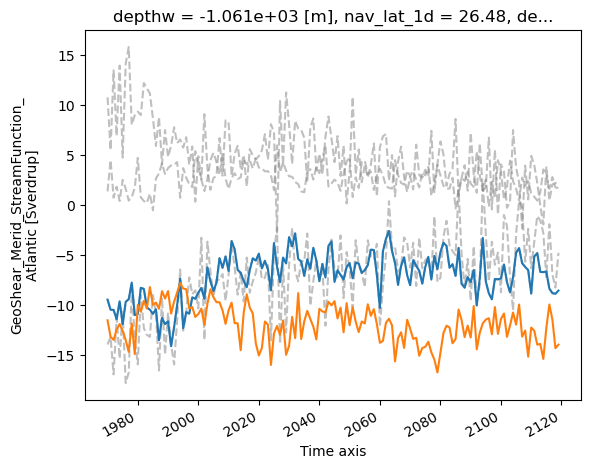

In [8]:
for at in amoc_parts:
    at.resample(time_counter = 'AS').mean().plot(x = 'time_counter', color = 'gray', linestyle = '--', alpha = .5)

amoc_total.resample(time_counter = 'AS').mean().plot(x = 'time_counter', label = 'total calc')
geo_moc.resample(time_counter = 'AS').mean().plot(x = 'time_counter', label = 'geo moc cdf')